# Simple_Moving_Average_Analysis
**Author**: Hansen Han  
**Date**: February 4th, 2023  

#### Load Data

In [1]:
# Load 1 min BTC data from 2013 to 2019
import pandas as pd

# handle minute data from 2014 to 2019
df2019 = pd.read_csv("BTC_1min_bitfinex/2019.txt", header=None)
df2018 = pd.read_csv("BTC_1min_bitfinex/2018.txt", header=None)
df2017 = pd.read_csv("BTC_1min_bitfinex/2017.txt", header=None)
df2016 = pd.read_csv("BTC_1min_bitfinex/2016.txt", header=None)
df2015 = pd.read_csv("BTC_1min_bitfinex/2015.txt", header=None)
df2014 = pd.read_csv("BTC_1min_bitfinex/2014.txt", header=None)

# handle hourly data from 2018 to 2023
df2018_2023 = pd.read_csv("BTC_1min_bitfinex/2018_2023.csv", skiprows=[0])
df2018_2023['volume'] = df2018_2023['Volume USD']
df2018_2023['timestamp'] = df2018_2023['date']
df2018_2023.drop(['unix', 'symbol', 'Volume BTC', 'Volume USD', 'date'], axis=1, inplace=True)
df2018_2023

# removed 2013 data
#df2013 = pd.read_csv("BTC_1min_bitfinex/2013.txt", header=None)
#frames = [df2013, df2014, df2015, df2016, df2017, df2018, df2019]

frames = [df2014, df2015, df2016, df2017, df2018, df2019]

crypto_df = pd.concat(frames)
crypto_df.rename(columns = {0: 'timestamp', 1: 'open', 2: 'close', 3: 'high', 4: 'low', 5: 'volume'}, inplace=True)

# Convert UTC timestamp to readable 
from datetime import datetime
crypto_df['timestamp'] = [datetime.utcfromtimestamp(int(ts)/1000).strftime('%Y-%m-%d %H:%M:%S') for ts in crypto_df['timestamp']]

def merge_and_convert_to_hourly(minute_data, hourly_data):
    # Convert timestamp column to datetime format
    minute_data['timestamp'] = pd.to_datetime(minute_data['timestamp'], format='%Y-%m-%d %H:%M:%S')
    hourly_data['timestamp'] = pd.to_datetime(hourly_data['timestamp'], format='%Y-%m-%d %H:%M:%S')

    # Filter minute_data to only include data from 2014 to 2018
    minute_data = minute_data[minute_data['timestamp'].dt.year < 2019]

    # Round minute_data timestamp to nearest hour
    minute_data['timestamp'] = minute_data['timestamp'].dt.floor('H')

    # Find the latest timestamp in minute_data
    latest_minute_timestamp = minute_data['timestamp'].max()

    # Filter hourly_data to only include data from after the latest timestamp in minute_data
    hourly_data = hourly_data[hourly_data['timestamp'] > latest_minute_timestamp]

    # Combine the two dataframes
    combined_data = pd.concat([minute_data, hourly_data])

    # Drop any duplicates
    combined_data = combined_data.drop_duplicates(subset='timestamp', keep='last')

    # Sort by timestamp
    combined_data = combined_data.sort_values('timestamp')

    # Set the timestamp column as the index
    combined_data = combined_data.set_index('timestamp')

    # Resample to hourly data
    combined_data = combined_data.resample('H').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })

    # Reset the index
    combined_data = combined_data.reset_index()

    return combined_data


crypto_df = merge_and_convert_to_hourly(crypto_df, df2018_2023)
crypto_df


/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,timestamp,open,high,low,close,volume
0,2014-01-01 00:00:00,739.2800,739.2800,739.2800,739.2800,1.500000e-01
1,2014-01-01 01:00:00,742.9989,742.9989,742.9989,742.9989,3.720000e+00
2,2014-01-01 02:00:00,748.4900,748.8900,748.4900,748.8900,5.740000e+00
3,2014-01-01 03:00:00,740.0000,743.1000,740.0000,740.0000,2.256364e+00
4,2014-01-01 04:00:00,745.3100,745.3100,745.3100,745.3100,1.745600e+00
...,...,...,...,...,...,...
80036,2023-02-17 20:00:00,24523.0000,25023.0000,24523.0000,24834.0000,1.012941e+07
80037,2023-02-17 21:00:00,24833.0000,24841.0000,24426.0000,24495.0000,4.186570e+06
80038,2023-02-17 22:00:00,24479.0000,24745.0000,24057.0000,24692.0000,5.983257e+06
80039,2023-02-17 23:00:00,24687.0000,24745.0000,24525.0000,24582.0000,1.484912e+06


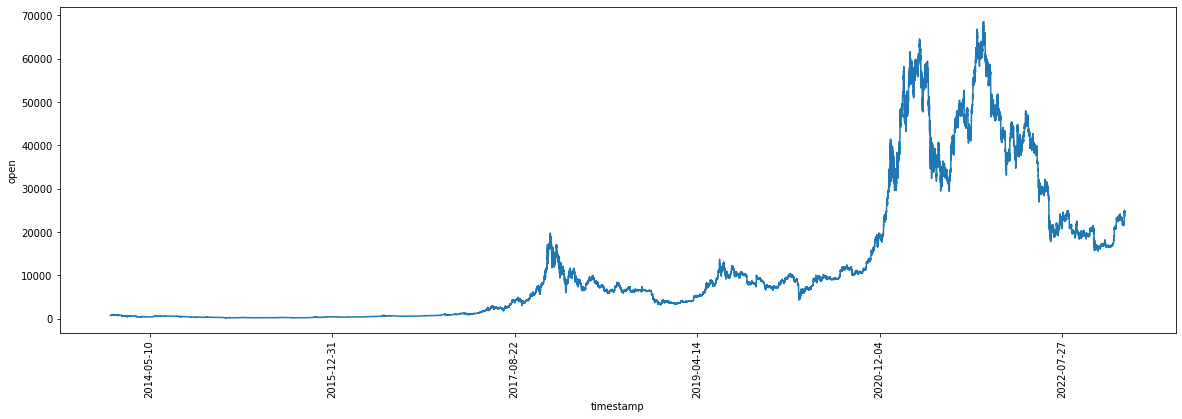

In [2]:
# View the data to make sure it looks right 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
#plt.style.use('dark_background')

#sns.set_context("talk")
plt.figure(figsize=(20,6))
ax = sns.lineplot(x="timestamp", y="open", 
            data=crypto_df, ci=None)
ax.xaxis.set_major_locator(ticker.MaxNLocator(7))
plt.xticks(rotation="vertical")

plt.show() # looks right...

#### Simple Moving Average (SMA) Crossover Strategy Backtesting

In [3]:
import numpy as np

def sma_crossover_backtester(sampled_data, 
                            order_sizing, 
                            ma1_length, 
                            ma2_length, 
                            starting_capital,
                            display_results):
    """ 
    Parameters:
        sampled_data: pandas dataframe that must have columns 'timestamp' and 'price'
        order_sizing: how much of available capital to use on a given trade (betwen 0 and 1)
        ma1_length: moving average 1 length (in hours)
        ma2_length: moving average 2 length (in hours, must be longer than ma1_length)
        starting_capital: how much capital to start with (USD)
        display_results: plot the portfolio value over time (true or false)
    Returns:
        backtest_results: dictionary that contains backtest result metrics and balance information 
    """
    
    import math 
    import statistics 
    import numpy as np
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    # Ensure inputs are valid
    if "timestamp" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'timestamp' column missing from data."
    if "price" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'price' column missing from data."
    if ma2_length < ma1_length:
        return "Could not run ma_crossover_backtester(), ma1_length is larger than ma2_length."
    if starting_capital <= 0:
        return "Could not run ma_crossover_backtester(), starting_capital must be greater than zero."
    if order_sizing > 1 or order_sizing <= 0:
        return "Could not run ma_crossover_backtester(), order_sizing must be between 1 and 0."
    
    
    fiat = starting_capital
    position_size = 0
    baseline_position_size = 0
    portfolio_balance = [] #keeps track of the total portfolio worth
    baseline_balance = [] #keeps track of the buy and hold balance
    moves = [] #keep track of buys and sells
    trades = 0
    purchase_price = 0
    wins = 0
    losses = 0

    # setup for keeping track of quarterly results
    three_month_hours = 2191
    one_month_hours = 730 #actually 730.5 
    quarter_numbers = []
    quarter_return_rates = []
    quarter_trades = []
    quarter_hit_rates = []
    baseline_return_rates = []

    monthly_return_rates = []

    # calculate the total number of quarters in the dataset
    total_quarters = math.floor(len(sampled_data.index)/three_month_hours)
    total_months = math.floor(len(sampled_data.index)/one_month_hours)

    # calculate quarter intervals
    quarter_intervals = [three_month_hours*x for x in range(0, total_quarters)]
    monthly_intervals = [one_month_hours*x for x in range(0, total_months)]

    # convert to get the corresponding timestamps
    quarter_intervals = [crypto_df.iloc[x]['timestamp'] for x in quarter_intervals]
    monthly_intervals = [crypto_df.iloc[x]['timestamp'] for x in monthly_intervals]
    
    current_price = sampled_data['price'][0]
    baseline_position_size = starting_capital/current_price
    baseline_initial = current_price

    ma1 = sampled_data.price.rolling(ma1_length).mean()
    ma2 = sampled_data.price.rolling(ma2_length).mean()

    #truncate the data so they all are aligned 
    ma1 = list(ma1[ma2_length:])
    ma2 = list(ma2[ma2_length:])
    sampled_data = sampled_data[ma2_length:]
    last_average_higher = "None"
    
    #now run through each moment in the data and check if there is a crossover
    for x in range(0, len(sampled_data['price'])):

        #get the current price
        current_price = list(sampled_data['price'])[x]

        if x == 0:
            #baseline_initial = current_price
            #baseline_position_size = starting_capital/current_price
            quarter_initial = current_price

            monthly_initial_balance = starting_capital
            quarter_initial_balance = starting_capital
            quarter_baseline_initial_balance = starting_capital
        
        # if a new month begins, calculate the return for that month (for sharpe ratio calculations)
        if sampled_data.iloc[x]['timestamp'] in monthly_intervals:
            monthly_return_rate = ((fiat + current_price*position_size)/monthly_initial_balance) - 1
            monthly_return_rates.append(monthly_return_rate)
            monthly_initial_balance = fiat + current_price*position_size

        # If a new quarter begins, calculate metrics for the quarter
        if sampled_data.iloc[x]['timestamp'] in quarter_intervals:
            quarter_return_rate = ((fiat + current_price*position_size)/quarter_initial_balance) - 1
            quarter_return_rates.append(quarter_return_rate)
            quarter_trades.append(trades)
            baseline_return_rate = ((baseline_position_size*current_price)/quarter_baseline_initial_balance) - 1
            baseline_return_rates.append(baseline_return_rate)

            if (losses + wins) > 0:
                hit_rate = wins/(losses + wins)
            else:
                hit_rate = "N/A"

            quarter_hit_rates.append(hit_rate)

            # reset initial price for the quarter
            quarter_initial = current_price

            # reset number of trades, losses, wins
            trades = 0
            losses = 0
            wins = 0

            # calculate the new initial portfolio worth to be used for the new quarter
            quarter_initial_balance = fiat + current_price*position_size
            quarter_baseline_initial_balance = current_price*baseline_position_size
            
            
        #keep track of which one was higher previously
        if ma1[x] > ma2[x]:
            current_average_higher = "MA1"
        elif ma1[x] < ma2[x]:
            current_average_higher = "MA2"
        else:
            current_average_higher = "None"

        if x == 0:
            moves.append("Pass")
        else:
            #begin the trading mechanism

            #if the shorter average crosses over the longer average - BUY
            if current_average_higher == "MA1" and last_average_higher == "MA2":
                #add the btc amount to the position
                position_size = position_size + (order_sizing*fiat)/current_price #add the btc purchased
                fiat = fiat - order_sizing*fiat #subtract the amount of capital used
                moves.append("Buy")
                trades = trades + 1
                purchase_price = current_price

            #if the shorter average goes under the longer average - SELL
            elif current_average_higher == "MA2" and last_average_higher == "MA1":
                fiat = fiat + position_size*current_price
                position_size = 0
                moves.append("Sell")
                trades = trades + 1

                # record whether the trade was profitable
                if purchase_price < current_price:
                    wins = wins + 1 
                else:
                    losses = losses + 1
                
                # reset the purchase price
                purchase_price = 0

            else:
                moves.append("Pass")
        
        #record the portfolio information
        portfolio_balance.append(position_size*current_price + fiat)
        baseline_balance.append(baseline_position_size*current_price)
        
        #record which moving average was higher this moment
        last_average_higher = current_average_higher
    
    # compute final results
    baseline_final = current_price
    baseline_return_rate = (baseline_final/baseline_initial) - 1    
    final_return_rate = (portfolio_balance[len(portfolio_balance) - 1]/starting_capital) - 1
    if (losses + wins) > 0:
        hit_rate = wins/(losses + wins)
    else:
        hit_rate = "N/A"

    # calculate sharpe ratio (using 0% as the risk-free return benchmark)
    sharpe_ratio = (statistics.mean(monthly_return_rates)-0)/(statistics.stdev(monthly_return_rates)*np.sqrt(12))

    # plot the final data
    plot_data = pd.DataFrame()
    plot_data['time'] = sampled_data['timestamp']
    plot_data['Baseline'] = baseline_balance
    plot_data['SMA Crossover'] = portfolio_balance

    if display_results == True:
        plt.figure(figsize=(20,6))
        plot_data.plot(x = "time")
        plt.xticks(rotation="vertical")
        plt.show()

    # return the results
    backtest_results = {"final_return_rate" : final_return_rate,
               "hit_rate": hit_rate,
               "baseline_return_rate": baseline_return_rate,
               "quarter_return_rates": quarter_return_rates, 
               "quarter_trades": quarter_trades,
               "quarter_hit_rates": quarter_hit_rates,
               "baseline_return_rates": baseline_return_rates,
               "balance_data": plot_data,
               "sharpe_ratio": sharpe_ratio

    }
    
    return backtest_results

def plot_quarterly_data(backtest_results):
    '''
    Visualize quarterly data from a backtest run.

    Parameters:
        backtest_results: dict generated by sma_crossover_backtester()
    Returns:
        None
    '''

    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    quarterly_data = pd.DataFrame()
    quarterly_data['quarter'] = [x + 1 for x in range(0, len(backtest_results["quarter_return_rates"]))]
    quarterly_data['return'] = [x*100 for x in backtest_results["quarter_return_rates"]]
    quarterly_data['trades'] = backtest_results["quarter_trades"]
    quarterly_data['hit_rate'] = backtest_results["quarter_hit_rates"]
    quarterly_data['baseline'] = [x*100 for x in backtest_results["baseline_return_rates"]]

    # Hit Rate
    clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
    graph = sns.barplot(x="quarter",y="hit_rate",data=quarterly_data,palette=clrs)
    #Drawing a horizontal line at 0.5
    graph.axhline(0.5)
    plt.show()

    # Returns
    clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
    graph = sns.barplot(x="quarter",y="return",data=quarterly_data,palette=clrs)
    plt.show()

    # Number of trades
    graph = sns.barplot(x="quarter",y="trades",data=quarterly_data,palette=clrs)
    plt.show()

    # Comparing quarterly returns
    comparison_df = pd.DataFrame()
    comparison_df['Return (%)']  = list(quarterly_data['return']) + list(quarterly_data['baseline'])
    comparison_df['Quarter'] = [x for x in quarterly_data['quarter']] + [x for x in quarterly_data['quarter']]
    comparison_df['Strategy'] = ["SMA Crossover" for x in quarterly_data['quarter']] + ["Buy and Hold" for x in quarterly_data['quarter']]

    sns.barplot(data=comparison_df, x='Quarter', y='Return (%)', hue='Strategy')
    plt.show()

<Figure size 1440x432 with 0 Axes>

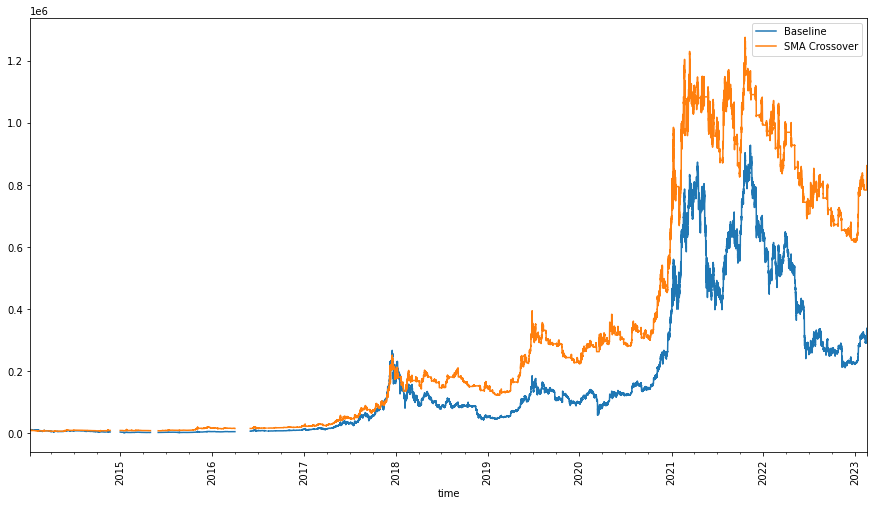

Sharpe Ratio: nan
Hit Rate: 0.38461538461538464
SMA Crossover Return Rate: 8361.39 %
Buy & Hold Return Rate: 3224.86 %
Median Return per Quarter: 1.29 %


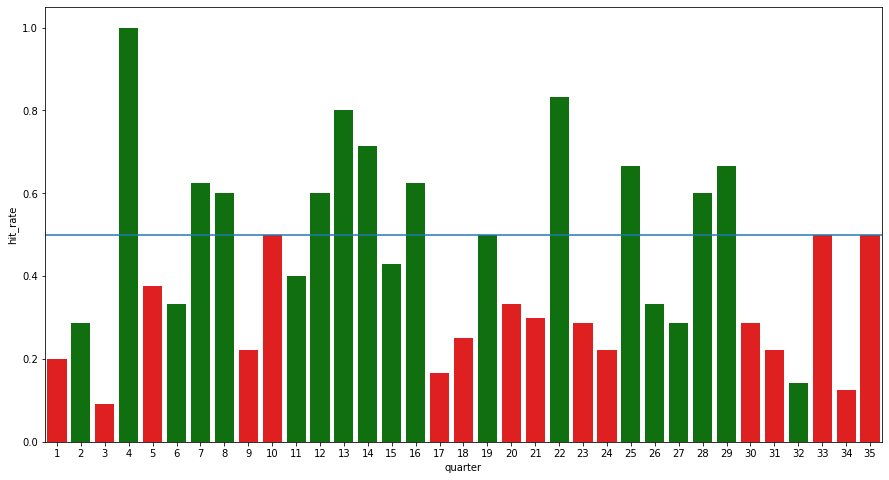

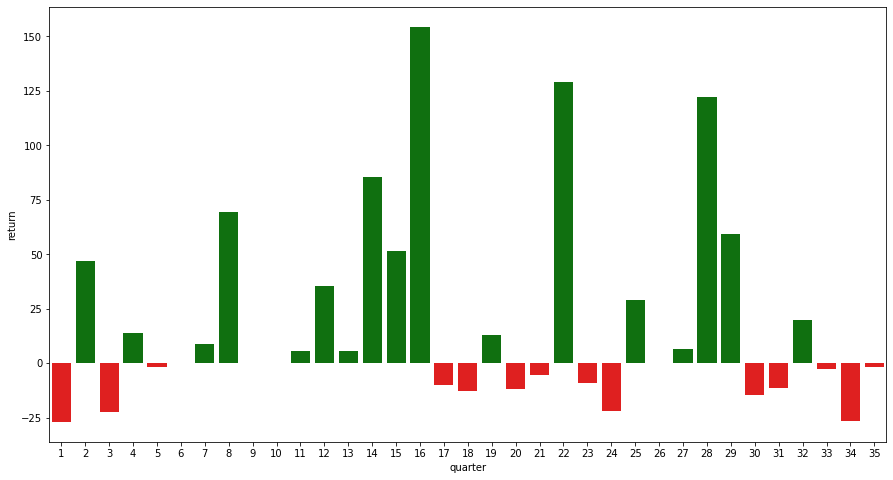

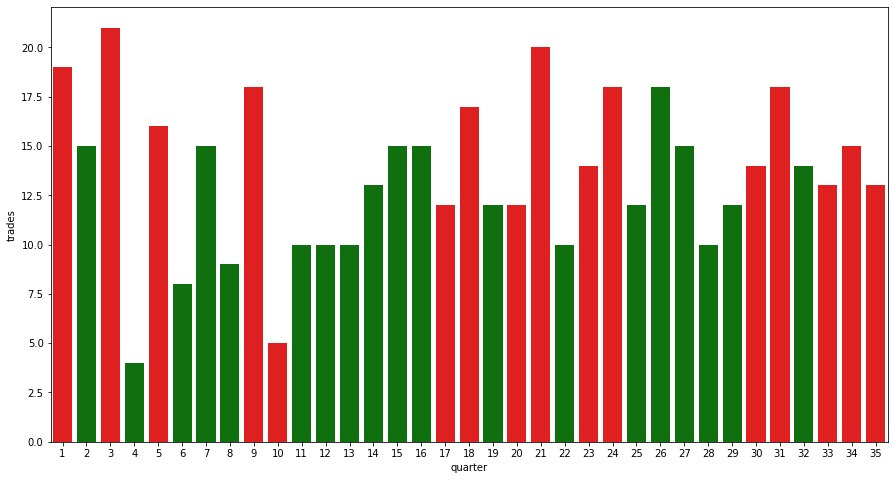

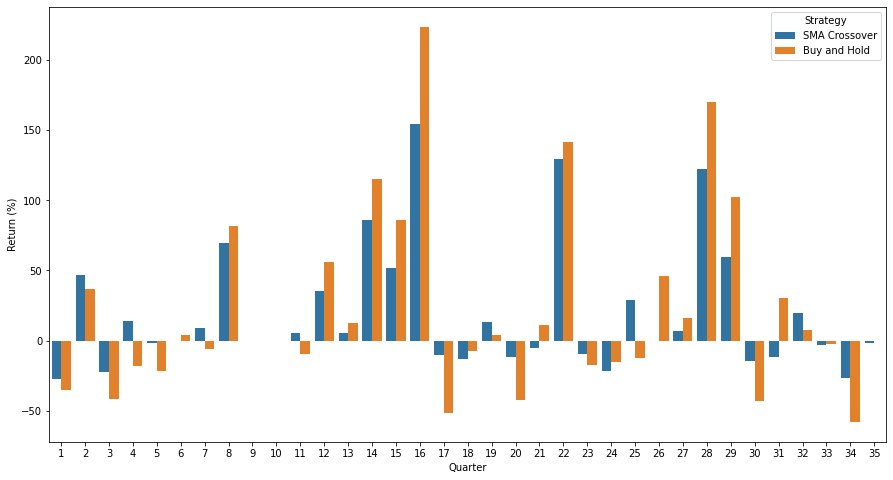

In [4]:
# Run the crossover backtester on the whole dataset 
crypto_df['price'] = crypto_df['open'] # set open to be the price to use 

backtest_results = sma_crossover_backtester(
            sampled_data = crypto_df,
            order_sizing = 1,
            ma1_length = 48, 
            ma2_length = 168, 
            starting_capital = 10000,
            display_results=True
        )

# Interpret backtest results
import statistics
print("Sharpe Ratio:", round(backtest_results['sharpe_ratio'],2))
print("Hit Rate:", backtest_results['hit_rate'])
print("SMA Crossover Return Rate:", round(backtest_results['final_return_rate']*100,2), "%")
print("Buy & Hold Return Rate:", round(backtest_results['baseline_return_rate']*100,2), "%")
print("Median Return per Quarter:", round(statistics.median(backtest_results['quarter_return_rates']*100), 2), "%")

plot_quarterly_data(backtest_results)

### Does short-selling improve performance? 

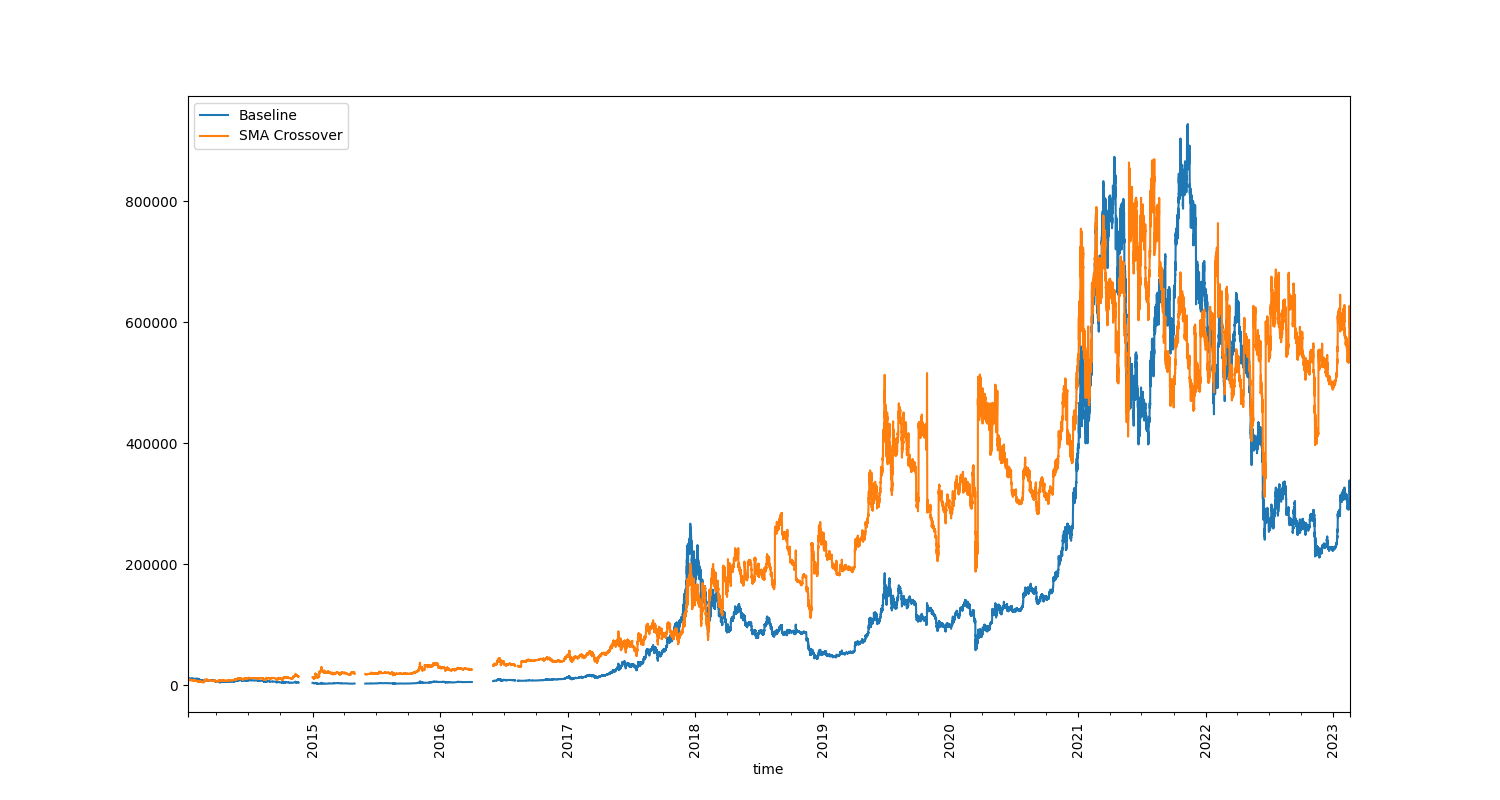

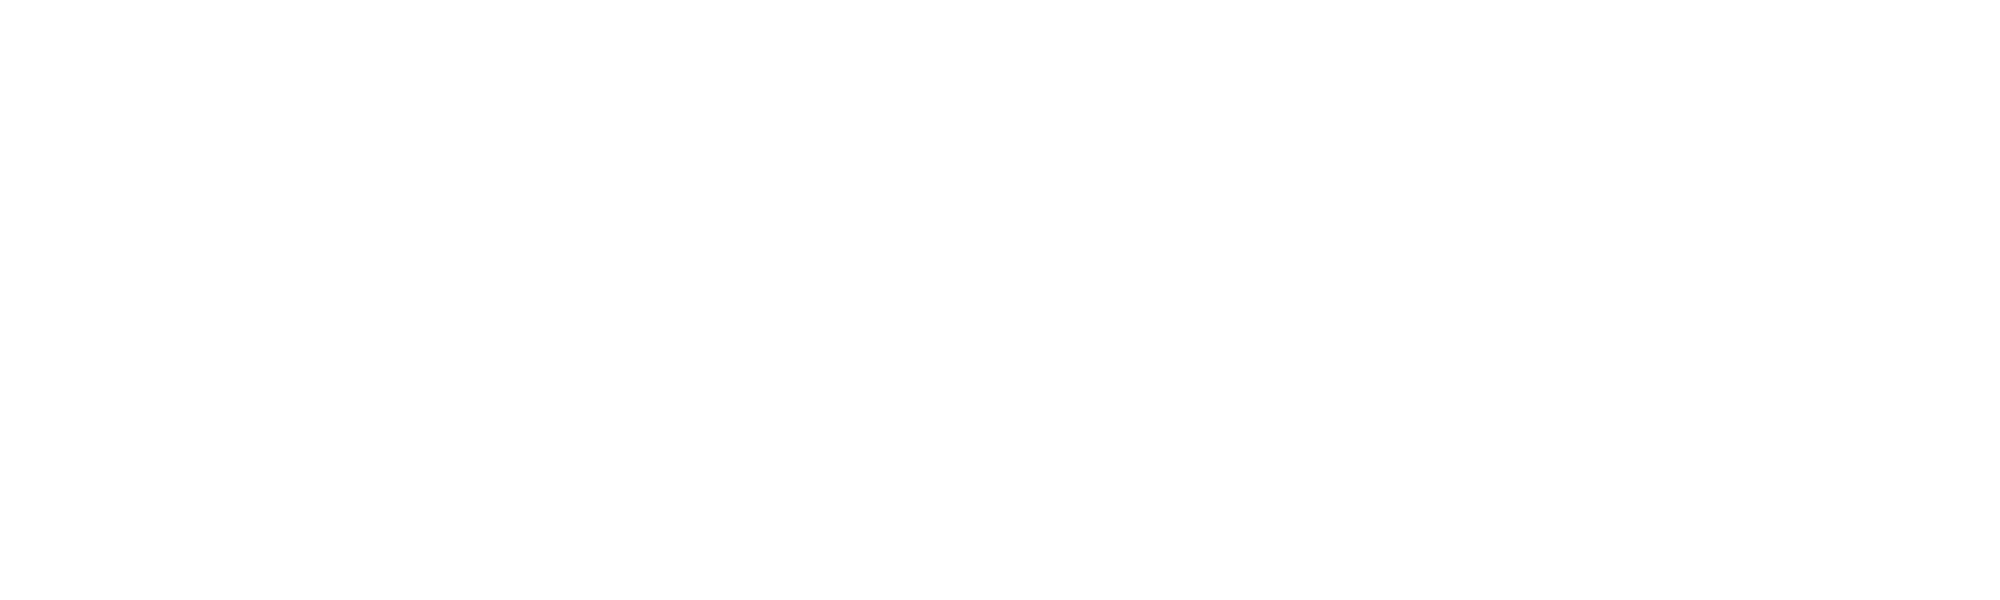

In [71]:

def sma_crossover_backtester_shorting(sampled_data, 
                            order_sizing, 
                            ma1_length, 
                            ma2_length, 
                            starting_capital,
                            display_results):
    """ 
    A modified version of sma_crossover_backtester() that performs short-selling instead of just closing the position when it gets a bear signal. 

    Parameters:
        sampled_data: pandas dataframe that must have columns 'timestamp' and 'price'
        order_sizing: how much of available capital to use on a given trade (betwen 0 and 1)
        ma1_length: moving average 1 length (in hours)
        ma2_length: moving average 2 length (in hours, must be longer than ma1_length)
        starting_capital: how much capital to start with (USD)
        display_results: plot the portfolio value over time (true or false)
    Returns:
        backtest_results: dictionary that contains backtest result metrics and balance information 
    """
    
    import math 
    import statistics 
    import numpy as np
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    # Ensure inputs are valid
    if "timestamp" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'timestamp' column missing from data."
    if "price" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'price' column missing from data."
    if ma2_length < ma1_length:
        return "Could not run ma_crossover_backtester(), ma1_length is larger than ma2_length."
    if starting_capital <= 0:
        return "Could not run ma_crossover_backtester(), starting_capital must be greater than zero."
    if order_sizing > 1 or order_sizing <= 0:
        return "Could not run ma_crossover_backtester(), order_sizing must be between 1 and 0."
    
    
    fiat = starting_capital
    position_size = 0
    baseline_position_size = 0
    portfolio_balance = [] #keeps track of the total portfolio worth
    baseline_balance = [] #keeps track of the buy and hold balance
    moves = [] #keep track of buys and sells
    trades = 0
    purchase_price = 0
    wins = 0
    losses = 0

    # setup for keeping track of quarterly results
    three_month_hours = 2191
    one_month_hours = 730 #actually 730.5 
    quarter_numbers = []
    quarter_return_rates = []
    quarter_trades = []
    quarter_hit_rates = []
    baseline_return_rates = []

    monthly_return_rates = []

    # calculate the total number of quarters in the dataset
    total_quarters = math.floor(len(sampled_data.index)/three_month_hours)
    total_months = math.floor(len(sampled_data.index)/one_month_hours)

    # calculate quarter intervals
    quarter_intervals = [three_month_hours*x for x in range(0, total_quarters)]
    monthly_intervals = [one_month_hours*x for x in range(0, total_months)]

    # convert to get the corresponding timestamps
    quarter_intervals = [crypto_df.iloc[x]['timestamp'] for x in quarter_intervals]
    monthly_intervals = [crypto_df.iloc[x]['timestamp'] for x in monthly_intervals]
    
    current_price = sampled_data['price'][0]
    baseline_position_size = starting_capital/current_price
    baseline_initial = current_price

    ma1 = sampled_data.price.rolling(ma1_length).mean()
    ma2 = sampled_data.price.rolling(ma2_length).mean()

    #truncate the data so they all are aligned 
    ma1 = list(ma1[ma2_length:])
    ma2 = list(ma2[ma2_length:])
    sampled_data = sampled_data[ma2_length:]
    last_average_higher = "None"
    short_position = None

    short_results = []
    
    #now run through each moment in the data and check if there is a crossover
    for x in range(0, len(sampled_data['price'])):

        #get the current price
        current_price = list(sampled_data['price'])[x]

        if x == 0:
            #baseline_initial = current_price
            #baseline_position_size = starting_capital/current_price
            quarter_initial = current_price

            monthly_initial_balance = starting_capital
            quarter_initial_balance = starting_capital
            quarter_baseline_initial_balance = starting_capital
        
        # if a new month begins, calculate the return for that month (for sharpe ratio calculations)
        if sampled_data.iloc[x]['timestamp'] in monthly_intervals:
            monthly_return_rate = ((fiat + current_price*position_size)/monthly_initial_balance) - 1
            monthly_return_rates.append(monthly_return_rate)
            monthly_initial_balance = fiat + current_price*position_size

        # If a new quarter begins, calculate metrics for the quarter
        if sampled_data.iloc[x]['timestamp'] in quarter_intervals:
            quarter_return_rate = ((fiat + current_price*position_size)/quarter_initial_balance) - 1
            quarter_return_rates.append(quarter_return_rate)
            quarter_trades.append(trades)
            baseline_return_rate = ((baseline_position_size*current_price)/quarter_baseline_initial_balance) - 1
            baseline_return_rates.append(baseline_return_rate)

            if (losses + wins) > 0:
                hit_rate = wins/(losses + wins)
            else:
                hit_rate = "N/A"

            quarter_hit_rates.append(hit_rate)

            # reset initial price for the quarter
            quarter_initial = current_price

            # reset number of trades, losses, wins
            trades = 0
            losses = 0
            wins = 0

            # add some amount to the amount for each quarter ($1,000 per year)
            #fiat = fiat + 250

            # calculate the new initial portfolio worth to be used for the new quarter
            quarter_initial_balance = fiat + current_price*position_size
            quarter_baseline_initial_balance = current_price*baseline_position_size

            
            
            
        #keep track of which one was higher previously
        if ma1[x] > ma2[x]:
            current_average_higher = "MA1"
        elif ma1[x] < ma2[x]:
            current_average_higher = "MA2"
        else:
            current_average_higher = "None"

        if x == 0:
            moves.append("Pass")
        else:
            #begin the trading mechanism

            #if the shorter average crosses over the longer average - BUY
            if current_average_higher == "MA1" and last_average_higher == "MA2":
                if short_position == True:
                    # if there is a short position, exit out of it
                    short_delta = (purchase_price*position_size - current_price*position_size) # calculate the delta for the short
                    short_results.append(short_delta)
                    fiat = fiat + purchase_price*position_size + short_delta # sell the position and the short
                    position_size = 0 # set the position to zero
                
                # perform a normal buy
                position_size = position_size + (order_sizing*fiat)/current_price #add the btc purchased
                fiat = fiat - order_sizing*fiat #subtract the amount of capital used
                                    
                moves.append("Buy")
                trades = trades + 1
                purchase_price = current_price
                short_position = False
                    


            #if the shorter average goes under the longer average - SELL
            elif current_average_higher == "MA2" and last_average_higher == "MA1":
                fiat = fiat + position_size*current_price # sell all the BTC
                position_size = 0 # reset position size 

                # rebuy with the current amount, according to position size
                position_size = (order_sizing*fiat)/current_price
                fiat = fiat - position_size*current_price

                moves.append("Short-Sell")
                trades = trades + 1

                # record whether the trade was profitable
                if purchase_price < current_price:
                    wins = wins + 1 
                else:
                    losses = losses + 1

                # reset the purchase price
                #purchase_price = 0
                purchase_price = current_price
                short_position = True

            else:
                moves.append("Pass")
        
        #record the portfolio information
        if short_position == False or short_position == None:
            portfolio_balance.append(position_size*current_price + fiat)
        if short_position == True:
            short_delta = 0 - (purchase_price*position_size - current_price*position_size)
            portfolio_balance.append(purchase_price*position_size + short_delta + fiat)
            

        baseline_balance.append(baseline_position_size*current_price)

        
        #record which moving average was higher this moment
        last_average_higher = current_average_higher
    
    # compute final results
    baseline_final = current_price
    baseline_return_rate = (baseline_final/baseline_initial) - 1    
    final_return_rate = (portfolio_balance[len(portfolio_balance) - 1]/starting_capital) - 1
    if (losses + wins) > 0:
        hit_rate = wins/(losses + wins)
    else:
        hit_rate = "N/A"

    # calculate sharpe ratio (using 0% as the risk-free return benchmark)
    sharpe_ratio = (statistics.mean(monthly_return_rates)-0)/(statistics.stdev(monthly_return_rates)*np.sqrt(12))

    # plot the final data
    plot_data = pd.DataFrame()
    plot_data['time'] = sampled_data['timestamp']
    plot_data['Baseline'] = baseline_balance
    plot_data['SMA Crossover'] = portfolio_balance

    if display_results == True:
        plt.figure(figsize=(20,6))
        plot_data.plot(x = "time")
        plt.xticks(rotation="vertical")
        plt.show()

    # return the results
    backtest_results = {"final_return_rate" : final_return_rate,
               "hit_rate": hit_rate,
               "baseline_return_rate": baseline_return_rate,
               "quarter_return_rates": quarter_return_rates, 
               "quarter_trades": quarter_trades,
               "quarter_hit_rates": quarter_hit_rates,
               "baseline_return_rates": baseline_return_rates,
               "balance_data": plot_data,
               "sharpe_ratio": sharpe_ratio,
               "short_results": short_results

    }
    
    return backtest_results


backtest_results = sma_crossover_backtester_shorting(
            sampled_data = crypto_df,
            order_sizing = 0.9,
            ma1_length = 48, 
            ma2_length = 168, 
            starting_capital = 10000,
            display_results=True
        )


In [72]:
import statistics
print("Sharpe Ratio:", round(backtest_results['sharpe_ratio'],2))
print("Hit Rate:", backtest_results['hit_rate'])
print("SMA Crossover Return Rate:", round(backtest_results['final_return_rate']*100,2), "%")
print("Buy & Hold Return Rate:", round(backtest_results['baseline_return_rate']*100,2), "%")
print("Median Return per Quarter:", round(statistics.median(backtest_results['quarter_return_rates']*100), 2), "%")

Sharpe Ratio: nan
Hit Rate: 0.3076923076923077
SMA Crossover Return Rate: 6064.74 %
Buy & Hold Return Rate: 3224.86 %
Median Return per Quarter: 0.82 %


In [73]:
# 35% of the shorting trades were profitable (which is actually higher than the buying)
len([x for x in backtest_results['short_results'] if x > 0])/len(backtest_results['short_results'])

0.3510204081632653

### What are the optimal parameters for SMA crossover strategy? 

In [5]:
def random_ma_length_generator():
    """
    Generate random moving averages for optimization purposes.
    """
    import random
    num1 = random.randrange(0, round(2191/2))
    num2 = random.randrange(0, round(2191/2))
    while num2 < num1:
        num2 = random.randrange(0, round(2191/2))
    
    return num1, num2

from tqdm import trange # for tracking progress

# test lots of combinations
ma_combinations = []
median_return_rate_results = []
stdev_return_rate_results = []
profitable_quarters_results = [] 
cumulative_return_results = []
cumulative_baseline_return_results = []
sharpe_ratios = []

# run 100 different combinations (this can take up to a few hours, depending on the number of combinations being tested)
for x in trange(100):
    ma1_length, ma2_length = random_ma_length_generator()
    ma_combinations.append((ma1_length, ma2_length))

    backtest_results = sma_crossover_backtester(
            sampled_data = crypto_df,
            order_sizing = 1,
            ma1_length = ma1_length, 
            ma2_length = ma2_length, 
            starting_capital = 10000,
            display_results=False
        )
    
    median_return_rate = statistics.median(backtest_results['quarter_return_rates'])
    stdev_return_rate = statistics.stdev(backtest_results['quarter_return_rates'])
    profitable_quarters = len([x for x in backtest_results['quarter_return_rates'] if x > 0])
    cumulative_return = backtest_results['final_return_rate']
    cumulative_baseline_return = backtest_results["baseline_return_rate"]
    sharpe_ratio = backtest_results["sharpe_ratio"]

    median_return_rate_results.append(median_return_rate)
    stdev_return_rate_results.append(stdev_return_rate)
    profitable_quarters_results.append(profitable_quarters)
    cumulative_return_results.append(cumulative_return)
    cumulative_baseline_return_results.append(cumulative_baseline_return)
    sharpe_ratios.append(sharpe_ratio)

# compile results into a table for exploration
optimization_results = pd.DataFrame()
optimization_results["ma1_length"] = [x[0] for x in ma_combinations]
optimization_results["ma2_length"] = [x[1] for x in ma_combinations]
optimization_results["median_return_rate"] = median_return_rate_results
optimization_results["stdev_return_rate"] = stdev_return_rate_results
optimization_results["cumulative_return"] = cumulative_return_results
optimization_results["cumulative_baseline_return"] = cumulative_baseline_return_results
optimization_results["profitable_quarters"] = profitable_quarters_results
optimization_results["sharpe_ratio"] = sharpe_ratios

optimization_results.head()

100%|██████████| 100/100 [12:55:48<00:00, 465.49s/it] 


,ma1_length,ma2_length,median_return_rate,stdev_return_rate,cumulative_return,cumulative_baseline_return,profitable_quarters,sharpe_ratio
0,65,1036,-0.187102,NaN,40.888623,32.248566,13,NaN
1,714,976,0.000000,NaN,59.106237,32.248566,15,NaN
2,912,969,0.000000,NaN,68.711630,32.248566,15,NaN
3,892,998,0.000000,NaN,63.803935,32.248566,15,NaN
4,313,979,-0.102508,NaN,39.634376,32.248566,12,NaN


In [6]:
# 80 out of 100 random runs was profitable
len(optimization_results[optimization_results.cumulative_return > optimization_results.cumulative_baseline_return])

80

In [7]:
# what are the parameters for the run with the highest cumulative returns?
optimization_results[optimization_results.cumulative_return == max(optimization_results['cumulative_return'])]

,ma1_length,ma2_length,median_return_rate,stdev_return_rate,cumulative_return,cumulative_baseline_return,profitable_quarters,sharpe_ratio
90,41,350,0.085123,NaN,189.545602,32.248566,20,NaN


In [8]:
# save optimization results to csv (since it takes so long!)
optimization_results.to_csv("sma_optimization_2014_2023_results_100_runs.csv")

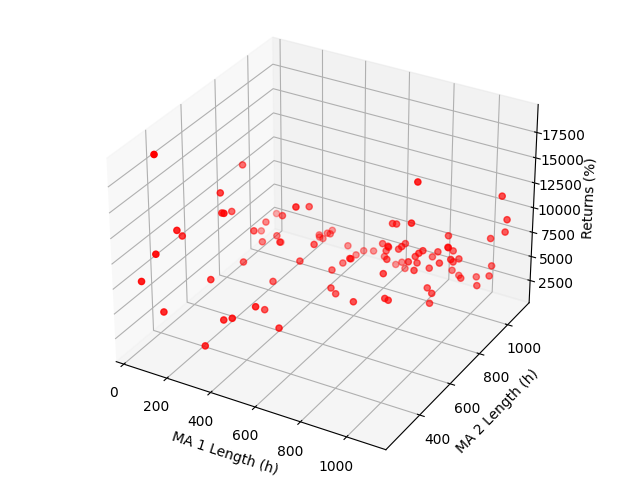

In [10]:
# For 2D plots
#sns.scatterplot(data=optimization_results, x="cumulative_return", y="stdev_return_rate")
#sns.scatterplot(data=optimization_results, x="cumulative_return", y="ma1_length")
#sns.scatterplot(data=optimization_results, x="cumulative_return", y="ma2_length")

optimization_results = pd.read_csv("sma_optimization_2014_2023_results_100_runs.csv")

# Create a 3D interactive plot to find relationships between moving average lengths and cumulative return rates
%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#plt.style.use('classic')

# Plot the data for the top 25% of cumulative returns
#xs = optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['ma1_length']
#ys = optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['ma2_length']
#zs = [x*100 for x in optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['cumulative_return']]

# Plot the data for all returns
xs = optimization_results['ma1_length']
ys = optimization_results['ma2_length']
zs = [x*100 for x in optimization_results['cumulative_return']]

# Also try using this instead of cumulative return to look at median return 
#zs = [x*100 for x in optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['median_return_rate']]
  
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
optimization_plot = ax.scatter(xs, ys, zs, color='red')
  
# setting title and labels
ax.set_title("Moving Average Length and Cumulative Returns")
ax.set_xlabel('MA 1 Length (h)')
ax.set_ylabel('MA 2 Length (h)')
ax.set_zlabel('Returns (%)')
  
# displaying the plot
plt.show()

- From briefly looking at the 3D plot, it looks like a long moving average between 200 and 400 hours, and a short moving average length between 0 and 200 hours yields the highest returns.